## This notebook is inspired by one of the homework problem from ECE C243 by Prof. J.C. Kao at UCLA

In [1]:
# Importing the necessary packages and the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
# import nsp as nsp
import pdb
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

   
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

def PlotSpikeRaster(S):
    gap = 3
    mark = 5
    pad = 30

    numSpikeTrains = np.size(S);
    for s in range(numSpikeTrains):
        offset = pad + gap + s*(gap+mark)
        train = S[s]
        if np.size(train)!=0 :
            train = train[:]
            for t in train.T :
                plt.plot([t,t], [offset, offset+mark], color=[0,0,0])

    plt.xlabel('Time (ms)')
    plt.ylim([0,offset+mark+gap+pad])
    
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(np.ceil(window_len/2-1)):int(np.ceil(-(window_len/2)))] 



def bin(X, binWidth,binType):
    [dims,numSamples] = X.shape
    if binType == 'first':
        numBins = np.ceil(float(numSamples)/binWidth).astype(int)
    else:
        numBins = np.floor(float(numSamples)/binWidth).astype(int)
    
    binX = np.zeros((dims, numBins),dtype = list)
    
    for i in range(numBins):
        binStart = i*binWidth
        binStop  = (i+1)*binWidth
        if binType == 'sum' :
            binX[:,i] = np.sum(X[:, binStart : binStop].todense(), 1).T
        elif binType == 'mean' :
            binX[:,i] = np.mean(X[:, binStart : binStop].todense(), 1).T
        elif binType ==  'first':
            binX[:,i] = np.asarray(X[:,binStart].todense().T)
        elif binType ==  'last':
            binX[:,i] = X[:, binStop]        
    return binX
  
  
 

Saving JR_2015-12-04_truncated2.mat to JR_2015-12-04_truncated2.mat
User uploaded file "JR_2015-12-04_truncated2.mat" with length 4914863 bytes


Answer:array([[1.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.025, 0.   ],
       [0.   , 0.   , 0.7  , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.7  , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])


### (b) Fit the A-matrix.
Calculate the hand velocities in $25$ ms intervals by using a first order Euler approximation, i.e.,

$$v(t) = \frac{cursorPos[t+25] -cursorPos[t]}{25}$$

Find and report the values in the $\mathbf{A}$ matrix.
To be clear, you should only be finding a matrix
\begin{eqnarray*}
\mathbf{A}_s = \left[ \begin{array}{cc} v_{xx} & v_{xy} \\ v_{yx} & v_{yy} \end{array} \right]
\end{eqnarray*}
and imputing those values into an $\mathbf{A}$ matrix that obeys physics.

In [3]:
#====================================================#
# YOUR CODE HERE:
#   Fit and report the 5x5 matrix A.
#====================================================#
train_num = 400
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
X_bin = bin(X, dt,'first')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
As = np.matmul(X_bin[:,1:], scipy.linalg.pinv(X_bin[:,0:-1]))
As

v_xx = As[0,0]
v_yy = As[1,1]
v_xy = As[0,1]
v_yx = As[1,0]
dt = 25
A = np.zeros((5,5))
A[0,2] = dt/1000
A[1,3] = dt/1000
A[0,0] = 1
A[1,1] = 1
A[2,2] = v_xx
A[2,3] = v_xy
A[3,2] = v_yx
A[3,3] = v_yy
A[4,4] = 1
A

#====================================================#
# END YOUR CODE
#====================================================#  

array([[ 1.        ,  0.        ,  0.025     ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.025     ,  0.        ],
       [ 0.        ,  0.        ,  0.77976907, -0.00741686,  0.        ],
       [ 0.        ,  0.        ,  0.0096132 ,  0.78079831,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [4]:
## Part c
#====================================================#
# YOUR CODE HERE:
#   Fit the C matrix, and report np.sum(C, 0)
#====================================================#
train_num = 400
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
Y_bin = bin(Y, dt,'sum').astype('float')
X_bin = bin(X, dt,'first').astype('float')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
X_bin = np.vstack((X_bin,np.ones(np.size(X_bin,1))))

Cs = np.matmul(Y_bin, scipy.linalg.pinv(X_bin))
C = np.hstack([np.zeros((np.size(Cs,0),2)), Cs])
np.sum(C,0)
#====================================================#
# END YOUR CODE
#====================================================#  

array([ 0.00000000e+00,  0.00000000e+00, -4.49938145e-03,  1.70531105e-03,
        4.01926529e+01])

*Answer*: Above

### (d)Fit the W matrix.

Find the $\mathbf{W}$ using the $\mathbf{A}$ matrix calculated in part (b).
We will only want to calculate an uncertainty over the velocity, and not on the positions.
Thus, you will perform the covariance calculation over the velocities, resulting in a $2 \times 2$ matrix $\mathbf{W}_s$.  
You will insert these values into the correct location in the $\mathbf{W}$ matrix, which is everywhere else $0$.
Report the $\mathbf{W}$ matrix.

In [5]:
## Part d
#====================================================#
# YOUR CODE HERE:
#   Fit and report the W matrix.
#====================================================#
train_num = 400
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
X_bin = bin(X, dt,'first')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
As = np.matmul(X_bin[:,2:], scipy.linalg.pinv(X_bin[:,1:-1]))
K = X_bin.shape[1]
temp = X_bin[:,1:]-np.matmul(As,X_bin[:,0:-1])
Ws = 1/(K-1)*np.matmul(temp,temp.T)

W = np.zeros((5,5))
W[2,2] = Ws[0,0]
W[2,3] = Ws[0,1]
W[3,3] = Ws[1,1]
W[3,2] = Ws[1,0]
W
#====================================================#
# END YOUR CODE
#====================================================#  

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        , 11512.16163325,  -793.98967029,
            0.        ],
       [    0.        ,     0.        ,  -793.98967029, 12124.73889882,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ]])

### (e) Fit the Q matrix.
Find the $\mathbf{Q}$ matrix using the $\mathbf{C}$ matrix calculated in part (c).
Submit a plot of Q using `plt.imshow(Q)`.
        


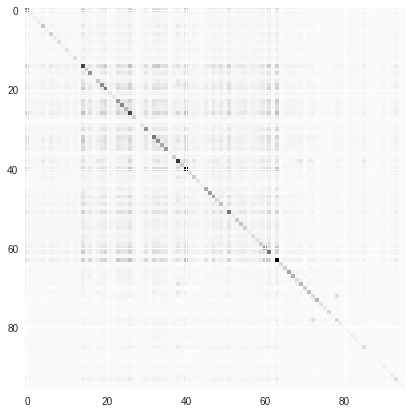

In [6]:
## Part e
#====================================================#
# YOUR CODE HERE:
#   Fit the Q matrix, and visuailze it using plt.imshow(Q)
#====================================================#
train_num = 400
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
Y_bin = bin(Y, dt,'sum').astype('float')
X_bin = bin(X, dt,'first').astype('float')
X_bin = np.matrix(np.diff(X_bin[0:2,:])/dt*1000, dtype = 'float')
#  add the 1 row
X_bin = np.vstack((X_bin,np.ones(np.size(X_bin,1))))

temp = Y_bin-np.matmul(Cs,X_bin)
Q = 1/K*np.matmul(temp,temp.T)
plt.figure(figsize=(7,7))
plt.imshow(Q)
#====================================================#
# END YOUR CODE
#====================================================#  

In [0]:
def KalmanSteadyState(A, W, C, Q):

    S_p = np.zeros((5,5)) # previous state estimate cov
    S_c = np.zeros((5,5)) # current state estimate cov
    S_c_p = np.zeros((5,5)) # transient state estimate cov
    M1_p = np.zeros((5,5)) # previous M1
    M1_c = np.ones((5,5)) # current M1
    M2_p = np.zeros((5,96)) # previous M2
    M2_c = np.ones((5,96)) # current M2
    tol = math.pow(10, -13)
    count = 0
    
    # Stopping criterion.
    it_d = np.hstack((M1_c.flatten() - M1_p.flatten(),  
                      M2_c.flatten()-M2_p.flatten()))

    while(np.max(np.abs(it_d)) > tol):
        
        #====================================================#
        # YOUR CODE HERE:
        #   Implement the Kalman filter recursion.
        #====================================================#
        dynamic_update = A@S_p@A.T + W
        S_c_p[2:,2:] = dynamic_update[2:,2:]
        K_k = S_c_p@C.T@np.linalg.pinv(C@S_c_p@C.T+Q)
        measurement_update = S_c_p \
                            - S_c_p@C.T@np.linalg.pinv(C@S_c_p@C.T+Q)@C@S_c_p   
        S_c[2:,2:] = measurement_update[2:,2:]

        M1_c = A-K_k@C@A
        M2_c = K_k

        it_d = np.hstack((M1_c.flatten() - M1_p.flatten(),  
                          M2_c.flatten()-M2_p.flatten()))

      # update the parameters
        S_p = S_c
        M1_p = M1_c
        M2_p = M2_c
        
        count = count + 1
#         print(np.max(np.abs(it_d)))
        #====================================================#
        # END YOUR CODE
        #====================================================#          
        
    S_st = S_c # steady state covariance
    K_st = M2_c # steady state Kalman gain
    
    return (M1_c,M2_c,S_st,K_st)

In [8]:
m1,m2,_,_ = KalmanSteadyState(A, W, C, Q)
print(m1)
print(np.sum(m2,1))

[[ 1.00000000e+00  0.00000000e+00  2.50000000e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  2.50000000e-02
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.77629013e-01 -2.53787898e-02
   1.23314734e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.54426706e-02  6.27592684e-01
  -5.85754563e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]]
[[  0.        ]
 [  0.        ]
 [-58.34287385]
 [126.7008201 ]
 [  0.        ]]


### (g) Decode using the KF.
Using the $\mathbf{M}_1$ and $\mathbf{M}_2$ matrix found in part (f), decode the neural activity for each trial in the testing data.
		Initialize $\mathbf{x}_0$ on each trial to be the starting position on the trial, and a velocity of $\mathbf{0}$.
		On one plot, show the true hand positions.
		On a separate plot, show the positions decoded by the Kalman filter.
       


In [1]:

train_num = 400
test_num = 106
pos_errors = []

X_bin_poss = np.empty((2,0))
X_bin_pos_hats = np.empty((2,0))


for i in range(test_num):
    X = R[train_num + i]['cursorPos']
    X = scipy.sparse.csc_matrix(X)
    X_bin_pos = bin(X, dt,'first')
    num_bin = X_bin_pos.shape[1]
    X_bin_pos = X_bin_pos[0:2,0:num_bin]
    if X.shape[1]%dt == 0:
      X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin]])
    else:
      X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin-1]])

# prepare Y_bin
    Y = R[train_num+i]['spikeRaster']
    Y_bin = bin(Y, dt,'sum')
    num_bins = Y_bin.shape[1]
# prepare the X matrices 
    X_bin_pos_hat = np.zeros((2,num_bins+1))


    X_bin_v_hat = np.zeros((2,num_bin+1))
    X_large_hat = np.zeros((5,num_bin+1))
    X_large_hat[-1,:] = np.ones((1,num_bin+1))
    # set initial position
    X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]

#   iterating the velocity and find position by integrating v   
#   for k in range(1,num_bins):
#     # predict velocity
#     X_hat_k = m1@X_large_hat[:,k-1] + m2@Y_bin[:,k].astype('float')
#     X_large_hat[2:4,k] = X_hat_k.flatten()[0,2:4]
#     # predict position by integrate over velocity
#     X_bin_pos_hat[:,k] = X_bin_pos_hat[:,k-1] + 0.025*np.array(X_large_hat[2:4,k-1]).flatten()
    for k in range(1,num_bins):
      # predict velocity
      X_hat_k = m1@X_large_hat[:,k-1] + m2@Y_bin[:,k].astype('float')
      X_large_hat[2:4,k] = X_hat_k.flatten()[0,2:4]

      # predict position by integrate over velocity
      X_bin_pos_hat[:,k] = X_bin_pos_hat[:,k-1] \
                                + 0.025*np.array(X_large_hat[2:4,k-1]).flatten()
 
  
    X_bin_pos_hats = np.hstack([X_bin_pos_hats, X_bin_pos_hat[:,0:num_bins]])
    diff_trial = (X_bin_pos[:,0:num_bin-1] - X_bin_pos_hat[:,0:num_bin-1])
    pos_errors.append(np.mean(np.sum(np.power(diff_trial,2),axis = 0)))


f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].plot(X_bin_poss[0,:],X_bin_poss[1,:], '.')
axs[0].set_title('True trojectory')
axs[0].set_xlim([-150, 150])
axs[0].set_ylim([-150, 150])

axs[1].plot(X_bin_pos_hats[0,:],X_bin_pos_hats[1,:], '.')
axs[1].set_title('Predicted trojectory')
# axs[1].set_xlim([-150, 150])
# axs[1].set_ylim([-150, 150])
print(np.mean(pos_errors))


#====================================================#
# END YOUR CODE
#====================================================#  

NameError: name 'np' is not defined

5.538399813030587e-31


(-150, 150)

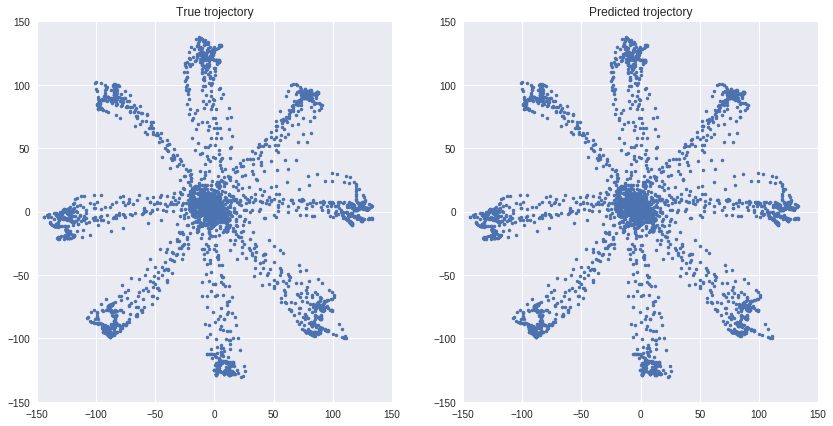

In [11]:
#====================================================#
# YOUR CODE HERE:
#   Decode the activity using a Kalman filter and
#   plot the decoded positions.
#====================================================#
#====================================================#
# YOUR CODE HERE:
#   Calculate the mean-squared error between the decoded
#   hand position and the true hand position.  Average
#   the squared errors across time; then average the squared
#   errors across trials.
#====================================================#
pass

test_num = 106
pos_errors = []

X_bin_poss = np.empty((2,0))
X_bin_pos_hats = np.empty((2,0))


for i in range(test_num):
  X = R[train_num + i]['cursorPos']
  X = scipy.sparse.csc_matrix(X)
  X_bin_pos = bin(X, dt,'first')
  X_bin_v = np.matrix(np.diff(X_bin_pos[0:2,:])/dt*1000, dtype = 'float')

  num_bin = X_bin_pos.shape[1]
  X_bin_pos = X_bin_pos[0:2,0:num_bin]
  if X.shape[1]%dt == 0:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin]])
  else:
    X_bin_poss = np.hstack([X_bin_poss, X_bin_pos[0:2,0:num_bin-1]])

# prepare Y_bin
  Y = R[train_num+i]['spikeRaster']
  Y_bin = bin(Y, dt,'sum')
  num_bins = Y_bin.shape[1]
  # prepare the X matrices 
  X_bin_pos_hat = np.zeros((2,num_bins+1))
  X_bin_v_hat = np.zeros((2,num_bin+1))
  X_large_hat = np.zeros((5,num_bin+1))
  X_large_hat[-1,:] = np.ones((1,num_bin+1))
  
  # set initial position
  X_bin_pos_hat[:,0] = R[train_num+i]['cursorPos'][0:2,0]
#   iterating the velocity and find position by integrating v   
  if X.shape[1]%dt != 0:
    for k in range(1,num_bins):
      # predict velocity
      X_hat_k = m1@X_large_hat[:,k-1] + m2@Y_bin[:,k].astype('float')
      X_large_hat[2:4,k] = X_hat_k.flatten()[0,2:4]

      # predict position by integrate over velocity
      X_bin_pos_hat[:,k] = X_bin_pos_hat[:,k-1] + 0.025*np.array(X_bin_v[:,k-1]).flatten()
  else:
    for k in range(0,num_bins-1):
# predict velocity
      X_hat_k = m1@X_large_hat[:,k-1] + m2@Y_bin[:,k].astype('float')
      X_large_hat[2:4,k] = X_hat_k.flatten()[0,2:4]

      # predict position by integrate over velocity
      X_bin_pos_hat[:,k+1] = X_bin_pos_hat[:,k] + 0.025*np.array(X_bin_v[:,k]).flatten()
  
  X_bin_pos_hats = np.hstack([X_bin_pos_hats, X_bin_pos_hat[:,0:num_bin]])
  
  diff_trial = (X_bin_pos[:,0:num_bin-1] - X_bin_pos_hat[:,0:num_bin-1])
  pos_errors.append(np.mean(np.sum(np.power(diff_trial,2),axis = 0))/dt)
  
print(np.mean(pos_errors))

f, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].plot(X_bin_poss[0,:],X_bin_poss[1,:], '.')
axs[0].set_title('True trojectory')
axs[0].set_xlim([-150, 150])
axs[0].set_ylim([-150, 150])

axs[1].plot(X_bin_pos_hats[0,:],X_bin_pos_hats[1,:], '.')
axs[1].set_title('Predicted trojectory')
axs[1].set_xlim([-150, 150])
axs[1].set_ylim([-150, 150])

#====================================================#
# END YOUR CODE
#====================================================#  